<a href="https://colab.research.google.com/github/yolandaazzahra/TaskWeek5/blob/main/TaskWeek5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Yolanda Azzahra

NPM : 2306319514

In [1]:
!pip install d2l==1.0.3


**9.1. Working with Sequences**

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

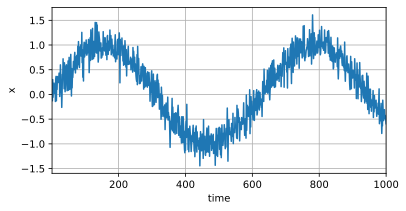

In [4]:
data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [5]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

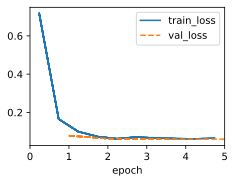

In [6]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

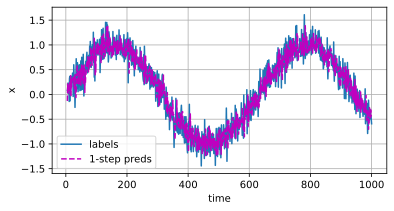

In [7]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

In [8]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

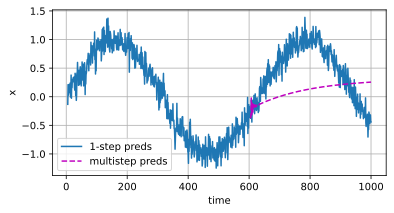

In [9]:
d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

In [10]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

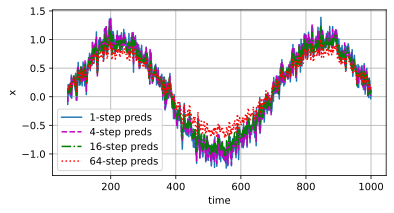

In [11]:
steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

**9.2. Converting Raw Text into Sequence Data**

In [12]:
import collections
import random
import re
import torch
from d2l import torch as d2l

In [13]:
class TimeMachine(d2l.DataModule):
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [14]:
@d2l.add_to_class(TimeMachine)
def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

In [15]:
@d2l.add_to_class(TimeMachine)
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

In [16]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [17]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [18]:
@d2l.add_to_class(TimeMachine)
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

In [19]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

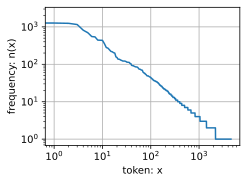

In [20]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

In [21]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

In [22]:
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

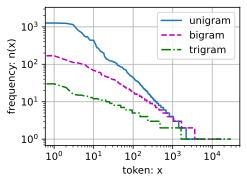

In [23]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

**9.3. Language Models**

In [24]:
import torch
from d2l import torch as d2l

In [25]:
@d2l.add_to_class(d2l.TimeMachine)
def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
    super(d2l.TimeMachine, self).__init__()
    self.save_hyperparameters()
    corpus, self.vocab = self.build(self._download())
    array = torch.tensor([corpus[i:i+num_steps+1]
                        for i in range(len(corpus)-num_steps)])
    self.X, self.Y = array[:,:-1], array[:,1:]

In [26]:
@d2l.add_to_class(d2l.TimeMachine)
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(
        self.num_train, self.num_train + self.num_val)
    return self.get_tensorloader([self.X, self.Y], train, idx)

In [27]:
data = d2l.TimeMachine(batch_size=2, num_steps=10)
for X, Y in data.train_dataloader():
    print('X:', X, '\nY:', Y)
    break

X: tensor([[ 6, 19, 26,  0, 19,  6, 14,  2, 19, 12],
        [ 2,  0,  4, 22,  3,  6,  0,  9,  2, 23]]) 
Y: tensor([[19, 26,  0, 19,  6, 14,  2, 19, 12,  2],
        [ 0,  4, 22,  3,  6,  0,  9,  2, 23,  6]])


**9.4. Recurrent Neural Networks**

In [28]:
import torch
from d2l import torch as d2l

In [29]:
X, W_xh = torch.randn(3, 1), torch.randn(1, 4)
H, W_hh = torch.randn(3, 4), torch.randn(4, 4)
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[ 1.3379,  0.2840,  3.0439,  2.0827],
        [-0.5492, -1.3683,  1.9716, -0.2026],
        [-1.5006, -1.0853, -1.8970, -3.4329]])

In [30]:
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[ 1.3379,  0.2840,  3.0439,  2.0827],
        [-0.5492, -1.3683,  1.9716, -0.2026],
        [-1.5006, -1.0853, -1.8970, -3.4329]])

**9.5. Recurrent Neural Network Implementation from Scratch**

In [31]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [32]:
class RNNScratch(d2l.Module):
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

In [33]:
@d2l.add_to_class(RNNScratch)
def forward(self, inputs, state=None):
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)
        state = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
    else:
        state, = state
    outputs = []
    for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
        state = torch.tanh(torch.matmul(X, self.W_xh) +
                         torch.matmul(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs, state

In [34]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [35]:
def check_len(a, n):
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

In [36]:
class RNNLMScratch(d2l.Classifier):
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

In [37]:
F.one_hot(torch.tensor([0, 2]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

In [38]:
@d2l.add_to_class(RNNLMScratch)
def one_hot(self, X):
    # Output shape: (num_steps, batch_size, vocab_size)
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)

In [39]:
@d2l.add_to_class(RNNLMScratch)
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    return torch.stack(outputs, 1)

@d2l.add_to_class(RNNLMScratch)
def forward(self, X, state=None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    return self.output_layer(rnn_outputs)

In [40]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))

In [41]:
@d2l.add_to_class(d2l.Trainer)
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

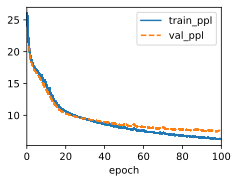

In [42]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [43]:
@d2l.add_to_class(RNNLMScratch)
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [44]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has of the time travell'

**9.6. Concise Implementation of Recurrent Neural Networks**

In [45]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [46]:
class RNN(d2l.Module):
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

In [47]:
class RNNLM(d2l.RNNLMScratch):
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

In [48]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)

'it hasjjvjvdjvdjvdjvdjvdjv'

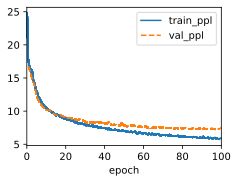

In [49]:
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [50]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has and the preal the p'

### **9.7 Backpropagation Through Time**
:label:`sec_bptt`

If you completed the exercises in :numref:`sec_rnn-scratch`,
you would have seen that gradient clipping is vital
for preventing the occasional massive gradients
from destabilizing training.
We hinted that the exploding gradients
stem from backpropagating across long sequences.
Before introducing a slew of modern RNN architectures,
let's take a closer look at how *backpropagation*
works in sequence models in mathematical detail.
Hopefully, this discussion will bring some precision
to the notion of *vanishing* and *exploding* gradients.
If you recall our discussion of forward and backward
propagation through computational graphs
when we introduced MLPs in :numref:`sec_backprop`,
then forward propagation in RNNs
should be relatively straightforward.
Applying backpropagation in RNNs
is called *backpropagation through time* :cite:`Werbos.1990`.
This procedure requires us to expand (or unroll)
the computational graph of an RNN
one time step at a time.
The unrolled RNN is essentially
a feedforward neural network
with the special property
that the same parameters
are repeated throughout the unrolled network,
appearing at each time step.
Then, just as in any feedforward neural network,
we can apply the chain rule,
backpropagating gradients through the unrolled net.
The gradient with respect to each parameter
must be summed across all places
that the parameter occurs in the unrolled net.
Handling such weight tying should be familiar
from our chapters on convolutional neural networks.


Complications arise because sequences
can be rather long.
It is not unusual to work with text sequences
consisting of over a thousand tokens.
Note that this poses problems both from
a computational (too much memory)
and optimization (numerical instability)
standpoint.
Input from the first step passes through
over 1000 matrix products before arriving at the output,
and another 1000 matrix products
are required to compute the gradient.
We now analyze what can go wrong and
how to address it in practice.


## Analysis of Gradients in RNNs
:label:`subsec_bptt_analysis`

We start with a simplified model of how an RNN works.
This model ignores details about the specifics
of the hidden state and how it is updated.
The mathematical notation here
does not explicitly distinguish
scalars, vectors, and matrices.
We are just trying to develop some intuition.
In this simplified model,
we denote $h_t$ as the hidden state,
$x_t$ as input, and $o_t$ as output
at time step $t$.
Recall our discussions in
:numref:`subsec_rnn_w_hidden_states`
that the input and the hidden state
can be concatenated before being multiplied
by one weight variable in the hidden layer.
Thus, we use $w_\textrm{h}$ and $w_\textrm{o}$ to indicate the weights
of the hidden layer and the output layer, respectively.
As a result, the hidden states and outputs
at each time step are

$$\begin{aligned}h_t &= f(x_t, h_{t-1}, w_\textrm{h}),\\o_t &= g(h_t, w_\textrm{o}),\end{aligned}$$
:eqlabel:`eq_bptt_ht_ot`

where $f$ and $g$ are transformations
of the hidden layer and the output layer, respectively.
Hence, we have a chain of values
$\{\ldots, (x_{t-1}, h_{t-1}, o_{t-1}), (x_{t}, h_{t}, o_t), \ldots\}$
that depend on each other via recurrent computation.
The forward propagation is fairly straightforward.
All we need is to loop through the $(x_t, h_t, o_t)$ triples one time step at a time.
The discrepancy between output $o_t$ and the desired target $y_t$
is then evaluated by an objective function
across all the $T$ time steps as

$$L(x_1, \ldots, x_T, y_1, \ldots, y_T, w_\textrm{h}, w_\textrm{o}) = \frac{1}{T}\sum_{t=1}^T l(y_t, o_t).$$



For backpropagation, matters are a bit trickier,
especially when we compute the gradients
with regard to the parameters $w_\textrm{h}$ of the objective function $L$.
To be specific, by the chain rule,

$$\begin{aligned}\frac{\partial L}{\partial w_\textrm{h}}  & = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial w_\textrm{h}}  \\& = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial o_t} \frac{\partial g(h_t, w_\textrm{o})}{\partial h_t}  \frac{\partial h_t}{\partial w_\textrm{h}}.\end{aligned}$$
:eqlabel:`eq_bptt_partial_L_wh`

The first and the second factors of the
product in :eqref:`eq_bptt_partial_L_wh`
are easy to compute.
The third factor $\partial h_t/\partial w_\textrm{h}$ is where things get tricky,
since we need to recurrently compute the effect of the parameter $w_\textrm{h}$ on $h_t$.
According to the recurrent computation
in :eqref:`eq_bptt_ht_ot`,
$h_t$ depends on both $h_{t-1}$ and $w_\textrm{h}$,
where computation of $h_{t-1}$
also depends on $w_\textrm{h}$.
Thus, evaluating the total derivate of $h_t$
with respect to $w_\textrm{h}$ using the chain rule yields

$$\frac{\partial h_t}{\partial w_\textrm{h}}= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}} +\frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_\textrm{h}}.$$
:eqlabel:`eq_bptt_partial_ht_wh_recur`


To derive the above gradient, assume that we have
three sequences $\{a_{t}\},\{b_{t}\},\{c_{t}\}$
satisfying $a_{0}=0$ and $a_{t}=b_{t}+c_{t}a_{t-1}$ for $t=1, 2,\ldots$.
Then for $t\geq 1$, it is easy to show

$$a_{t}=b_{t}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t}c_{j}\right)b_{i}.$$
:eqlabel:`eq_bptt_at`

By substituting $a_t$, $b_t$, and $c_t$ according to

$$\begin{aligned}a_t &= \frac{\partial h_t}{\partial w_\textrm{h}},\\
b_t &= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}}, \\
c_t &= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}},\end{aligned}$$

the gradient computation in :eqref:`eq_bptt_partial_ht_wh_recur` satisfies
$a_{t}=b_{t}+c_{t}a_{t-1}$.
Thus, per :eqref:`eq_bptt_at`,
we can remove the recurrent computation
in :eqref:`eq_bptt_partial_ht_wh_recur` with

$$\frac{\partial h_t}{\partial w_\textrm{h}}=\frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t} \frac{\partial f(x_{j},h_{j-1},w_\textrm{h})}{\partial h_{j-1}} \right) \frac{\partial f(x_{i},h_{i-1},w_\textrm{h})}{\partial w_\textrm{h}}.$$
:eqlabel:`eq_bptt_partial_ht_wh_gen`

While we can use the chain rule to compute $\partial h_t/\partial w_\textrm{h}$ recursively,
this chain can get very long whenever $t$ is large.
Let's discuss a number of strategies for dealing with this problem.

### Full Computation ###

One idea might be to compute the full sum in :eqref:`eq_bptt_partial_ht_wh_gen`.
However, this is very slow and gradients can blow up,
since subtle changes in the initial conditions
can potentially affect the outcome a lot.
That is, we could see things similar to the butterfly effect,
where minimal changes in the initial conditions
lead to disproportionate changes in the outcome.
This is generally undesirable.
After all, we are looking for robust estimators that generalize well.
Hence this strategy is almost never used in practice.

### Truncating Time Steps###

Alternatively,
we can truncate the sum in
:eqref:`eq_bptt_partial_ht_wh_gen`
after $\tau$ steps.
This is what we have been discussing so far.
This leads to an *approximation* of the true gradient,
simply by terminating the sum at $\partial h_{t-\tau}/\partial w_\textrm{h}$.
In practice this works quite well.
It is what is commonly referred to as truncated
backpropgation through time :cite:`Jaeger.2002`.
One of the consequences of this is that the model
focuses primarily on short-term influence
rather than long-term consequences.
This is actually *desirable*, since it biases the estimate
towards simpler and more stable models.


### Randomized Truncation ###

Last, we can replace $\partial h_t/\partial w_\textrm{h}$
by a random variable which is correct in expectation
but truncates the sequence.
This is achieved by using a sequence of $\xi_t$
with predefined $0 \leq \pi_t \leq 1$,
where $P(\xi_t = 0) = 1-\pi_t$ and
$P(\xi_t = \pi_t^{-1}) = \pi_t$, thus $E[\xi_t] = 1$.
We use this to replace the gradient
$\partial h_t/\partial w_\textrm{h}$
in :eqref:`eq_bptt_partial_ht_wh_recur`
with

$$z_t= \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial w_\textrm{h}} +\xi_t \frac{\partial f(x_{t},h_{t-1},w_\textrm{h})}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_\textrm{h}}.$$


It follows from the definition of $\xi_t$
that $E[z_t] = \partial h_t/\partial w_\textrm{h}$.
Whenever $\xi_t = 0$ the recurrent computation
terminates at that time step $t$.
This leads to a weighted sum of sequences of varying lengths,
where long sequences are rare but appropriately overweighted.
This idea was proposed by
:citet:`Tallec.Ollivier.2017`.

### Comparing Strategies

![Comparing strategies for computing gradients in RNNs. From top to bottom: randomized truncation, regular truncation, and full computation.](../img/truncated-bptt.svg)
:label:`fig_truncated_bptt`


:numref:`fig_truncated_bptt` illustrates the three strategies
when analyzing the first few characters of *The Time Machine*
using backpropagation through time for RNNs:

* The first row is the randomized truncation that partitions the text into segments of varying lengths.
* The second row is the regular truncation that breaks the text into subsequences of the same length. This is what we have been doing in RNN experiments.
* The third row is the full backpropagation through time that leads to a computationally infeasible expression.


Unfortunately, while appealing in theory,
randomized truncation does not work
much better than regular truncation,
most likely due to a number of factors.
First, the effect of an observation
after a number of backpropagation steps
into the past is quite sufficient
to capture dependencies in practice.
Second, the increased variance counteracts the fact
that the gradient is more accurate with more steps.
Third, we actually *want* models that have only
a short range of interactions.
Hence, regularly truncated backpropagation through time
has a slight regularizing effect that can be desirable.

## Backpropagation Through Time in Detail

After discussing the general principle,
let's discuss backpropagation through time in detail.
In contrast to the analysis in :numref:`subsec_bptt_analysis`,
in the following we will show how to compute
the gradients of the objective function
with respect to all the decomposed model parameters.
To keep things simple, we consider
an RNN without bias parameters,
whose activation function in the hidden layer
uses the identity mapping ($\phi(x)=x$).
For time step $t$, let the single example input
and the target be $\mathbf{x}_t \in \mathbb{R}^d$ and $y_t$, respectively.
The hidden state $\mathbf{h}_t \in \mathbb{R}^h$
and the output $\mathbf{o}_t \in \mathbb{R}^q$
are computed as

$$\begin{aligned}\mathbf{h}_t &= \mathbf{W}_\textrm{hx} \mathbf{x}_t + \mathbf{W}_\textrm{hh} \mathbf{h}_{t-1},\\
\mathbf{o}_t &= \mathbf{W}_\textrm{qh} \mathbf{h}_{t},\end{aligned}$$

where $\mathbf{W}_\textrm{hx} \in \mathbb{R}^{h \times d}$, $\mathbf{W}_\textrm{hh} \in \mathbb{R}^{h \times h}$, and
$\mathbf{W}_\textrm{qh} \in \mathbb{R}^{q \times h}$
are the weight parameters.
Denote by $l(\mathbf{o}_t, y_t)$
the loss at time step $t$.
Our objective function,
the loss over $T$ time steps
from the beginning of the sequence is thus

$$L = \frac{1}{T} \sum_{t=1}^T l(\mathbf{o}_t, y_t).$$


In order to visualize the dependencies among
model variables and parameters during computation
of the RNN,
we can draw a computational graph for the model,
as shown in :numref:`fig_rnn_bptt`.
For example, the computation of the hidden states of time step 3,
$\mathbf{h}_3$, depends on the model parameters
$\mathbf{W}_\textrm{hx}$ and $\mathbf{W}_\textrm{hh}$,
the hidden state of the previous time step $\mathbf{h}_2$,
and the input of the current time step $\mathbf{x}_3$.

![Computational graph showing dependencies for an RNN model with three time steps. Boxes represent variables (not shaded) or parameters (shaded) and circles represent operators.](../img/rnn-bptt.svg)
:label:`fig_rnn_bptt`

As just mentioned, the model parameters in :numref:`fig_rnn_bptt`
are $\mathbf{W}_\textrm{hx}$, $\mathbf{W}_\textrm{hh}$, and $\mathbf{W}_\textrm{qh}$.
Generally, training this model requires
gradient computation with respect to these parameters
$\partial L/\partial \mathbf{W}_\textrm{hx}$, $\partial L/\partial \mathbf{W}_\textrm{hh}$, and $\partial L/\partial \mathbf{W}_\textrm{qh}$.
According to the dependencies in :numref:`fig_rnn_bptt`,
we can traverse in the opposite direction of the arrows
to calculate and store the gradients in turn.
To flexibly express the multiplication of
matrices, vectors, and scalars of different shapes
in the chain rule,
we continue to use the $\textrm{prod}$ operator
as described in :numref:`sec_backprop`.


First of all, differentiating the objective function
with respect to the model output at any time step $t$
is fairly straightforward:

$$\frac{\partial L}{\partial \mathbf{o}_t} =  \frac{\partial l (\mathbf{o}_t, y_t)}{T \cdot \partial \mathbf{o}_t} \in \mathbb{R}^q.$$
:eqlabel:`eq_bptt_partial_L_ot`

Now we can calculate the gradient of the objective
with respect to the parameter $\mathbf{W}_\textrm{qh}$
in the output layer:
$\partial L/\partial \mathbf{W}_\textrm{qh} \in \mathbb{R}^{q \times h}$.
Based on :numref:`fig_rnn_bptt`,
the objective $L$ depends on $\mathbf{W}_\textrm{qh}$
via $\mathbf{o}_1, \ldots, \mathbf{o}_T$.
Using the chain rule yields

$$
\frac{\partial L}{\partial \mathbf{W}_\textrm{qh}}
= \sum_{t=1}^T \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{o}_t}, \frac{\partial \mathbf{o}_t}{\partial \mathbf{W}_\textrm{qh}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{o}_t} \mathbf{h}_t^\top,
$$

where $\partial L/\partial \mathbf{o}_t$
is given by :eqref:`eq_bptt_partial_L_ot`.

Next, as shown in :numref:`fig_rnn_bptt`,
at the final time step $T$,
the objective function
$L$ depends on the hidden state $\mathbf{h}_T$
only via $\mathbf{o}_T$.
Therefore, we can easily find the gradient
$\partial L/\partial \mathbf{h}_T \in \mathbb{R}^h$
using the chain rule:

$$\frac{\partial L}{\partial \mathbf{h}_T} = \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{o}_T}, \frac{\partial \mathbf{o}_T}{\partial \mathbf{h}_T} \right) = \mathbf{W}_\textrm{qh}^\top \frac{\partial L}{\partial \mathbf{o}_T}.$$
:eqlabel:`eq_bptt_partial_L_hT_final_step`

It gets trickier for any time step $t < T$,
where the objective function $L$ depends on
$\mathbf{h}_t$ via $\mathbf{h}_{t+1}$ and $\mathbf{o}_t$.
According to the chain rule,
the gradient of the hidden state
$\partial L/\partial \mathbf{h}_t \in \mathbb{R}^h$
at any time step $t < T$ can be recurrently computed as:


$$\frac{\partial L}{\partial \mathbf{h}_t} = \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{h}_{t+1}}, \frac{\partial \mathbf{h}_{t+1}}{\partial \mathbf{h}_t} \right) + \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{o}_t}, \frac{\partial \mathbf{o}_t}{\partial \mathbf{h}_t} \right) = \mathbf{W}_\textrm{hh}^\top \frac{\partial L}{\partial \mathbf{h}_{t+1}} + \mathbf{W}_\textrm{qh}^\top \frac{\partial L}{\partial \mathbf{o}_t}.$$
:eqlabel:`eq_bptt_partial_L_ht_recur`

For analysis, expanding the recurrent computation
for any time step $1 \leq t \leq T$ gives

$$\frac{\partial L}{\partial \mathbf{h}_t}= \sum_{i=t}^T {\left(\mathbf{W}_\textrm{hh}^\top\right)}^{T-i} \mathbf{W}_\textrm{qh}^\top \frac{\partial L}{\partial \mathbf{o}_{T+t-i}}.$$
:eqlabel:`eq_bptt_partial_L_ht`

We can see from :eqref:`eq_bptt_partial_L_ht`
that this simple linear example already
exhibits some key problems of long sequence models:
it involves potentially very large powers of $\mathbf{W}_\textrm{hh}^\top$.
In it, eigenvalues smaller than 1 vanish
and eigenvalues larger than 1 diverge.
This is numerically unstable,
which manifests itself in the form of vanishing
and exploding gradients.
One way to address this is to truncate the time steps
at a computationally convenient size
as discussed in :numref:`subsec_bptt_analysis`.
In practice, this truncation can also be effected
by detaching the gradient after a given number of time steps.
Later on, we will see how more sophisticated sequence models
such as long short-term memory can alleviate this further.

Finally, :numref:`fig_rnn_bptt` shows
that the objective function $L$
depends on model parameters $\mathbf{W}_\textrm{hx}$ and $\mathbf{W}_\textrm{hh}$
in the hidden layer via hidden states
$\mathbf{h}_1, \ldots, \mathbf{h}_T$.
To compute gradients with respect to such parameters
$\partial L / \partial \mathbf{W}_\textrm{hx} \in \mathbb{R}^{h \times d}$ and $\partial L / \partial \mathbf{W}_\textrm{hh} \in \mathbb{R}^{h \times h}$,
we apply the chain rule giving

$$
\begin{aligned}
\frac{\partial L}{\partial \mathbf{W}_\textrm{hx}}
&= \sum_{t=1}^T \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_\textrm{hx}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{x}_t^\top,\\
\frac{\partial L}{\partial \mathbf{W}_\textrm{hh}}
&= \sum_{t=1}^T \textrm{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_\textrm{hh}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{h}_{t-1}^\top,
\end{aligned}
$$

where $\partial L/\partial \mathbf{h}_t$
which is recurrently computed by
:eqref:`eq_bptt_partial_L_hT_final_step`
and :eqref:`eq_bptt_partial_L_ht_recur`
is the key quantity that affects the numerical stability.



Since backpropagation through time is the application of backpropagation in RNNs,
as we have explained in :numref:`sec_backprop`,
training RNNs alternates forward propagation with
backpropagation through time.
Moreover, backpropagation through time
computes and stores the above gradients in turn.
Specifically, stored intermediate values
are reused to avoid duplicate calculations,
such as storing $\partial L/\partial \mathbf{h}_t$
to be used in computation of both $\partial L / \partial \mathbf{W}_\textrm{hx}$
and $\partial L / \partial \mathbf{W}_\textrm{hh}$.


## Summary

Backpropagation through time is merely an application of backpropagation to sequence models with a hidden state.
Truncation, such as regular or randomized, is needed for computational convenience and numerical stability.
High powers of matrices can lead to divergent or vanishing eigenvalues. This manifests itself in the form of exploding or vanishing gradients.
For efficient computation, intermediate values are cached during backpropagation through time.



## Exercises

1. Assume that we have a symmetric matrix $\mathbf{M} \in \mathbb{R}^{n \times n}$ with eigenvalues $\lambda_i$ whose corresponding eigenvectors are $\mathbf{v}_i$ ($i = 1, \ldots, n$). Without loss of generality, assume that they are ordered in the order $|\lambda_i| \geq |\lambda_{i+1}|$.
   1. Show that $\mathbf{M}^k$ has eigenvalues $\lambda_i^k$.
   1. Prove that for a random vector $\mathbf{x} \in \mathbb{R}^n$, with high probability $\mathbf{M}^k \mathbf{x}$ will be very much aligned with the eigenvector $\mathbf{v}_1$
of $\mathbf{M}$. Formalize this statement.
   1. What does the above result mean for gradients in RNNs?
1. Besides gradient clipping, can you think of any other methods to cope with gradient explosion in recurrent neural networks?

[Discussions](https://discuss.d2l.ai/t/334)
